# dx-privacy preserving mechanism
![MADLIB mechanism](figure/MADLIB.png)

https://arxiv.org/pdf/1910.08902.pdf

## GPT2 with dx-privacy preserving mechanism

In [7]:
def mahalanobis_distance(x, mean, cov = 1):
    # Calculate the difference between the data point and the mean
    diff = x - mean
    # Calculate the Mahalanobis distance using the formula:
    # D(x) = sqrt((x - mean)^T * cov^-1 * (x - mean))
    inv_cov = np.linalg.inv(cov)
    mahalanobis_dist = np.sqrt(np.dot(np.dot(diff, inv_cov), diff))
    return mahalanobis_dist

In [86]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import AutoTokenizer, GPT2Config, AutoModelForCausalLM
import numpy as np

config = GPT2Config.from_pretrained('gpt2')
tokenizer = AutoTokenizer.from_pretrained('gpt2', use_fast=not False)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model = AutoModelForCausalLM.from_pretrained('gpt2', from_tf=bool(".ckpt" in 'gpt2'), config=config)

# word = "my secret number is 9 4 0 9 9 5"  # Replace with your target word

word = 'Charlie want to sell marijuana with his friend at Boston within two year'
len(word.split())

mechanism = 'gumbel'
#Privacy Preserving Mechanism
predicted_word_list = []
closest_token_list = []
for i in word.split():
    # Step 1: Retrieve the vector representation of the word
    inputs = tokenizer(i, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        # outputs = model(**inputs, output_hidden_states=True)
        outputs = model.get_input_embeddings()(inputs['input_ids'][0]).squeeze()

    vector_representation = outputs.numpy() #.hidden_states[-1].mean(dim=1).squeeze().numpy()
    if mechanism == 'multivariate':
        # Step 2: Perturb the vector representation with noise sampled from a multivariate distribution
        mean = np.zeros(model.transformer.wte.weight.shape[1])  # Mean of the multivariate distribution
        covariance = np.eye(model.transformer.wte.weight.shape[1])  # Covariance matrix of the distribution
        noise = np.random.multivariate_normal(mean, covariance, size=1)
        noisy_representation = vector_representation + noise
    if mechanism == 'normal':
        # Step 2: Perturb the vector representation with noise sampled from a normal distribution
        mean = 0.0  # Mean of the normal distribution
        std_dev = 0.1  # Standard deviation of the normal distribution
        noise = np.random.normal(mean, std_dev, size=vector_representation.shape)
        noisy_representation = vector_representation + noise
    if mechanism == 'gumbel':
        # Step 2: Perturb the vector representation with noise sampled from a gumbel normal distribution
        from torch.distributions.gumbel import Gumbel
        import torch
        b = 0.5 # Set β to your desired value
        gumbel_dist = Gumbel(0, b)
        num_samples = model.transformer.wte.weight.shape[1]
        gumbel_noise = gumbel_dist.sample((1, num_samples)).numpy()
        # gumbel_noise is now a tensor of shape (1, 768) containing 768 samples from the Gumbel distribution
        noisy_representation = vector_representation + gumbel_noise

    # Step 3: Project the noisy representation of the word back to the discrete vocabulary space
    # Find the token that is closest in embedding space to the noisy representation
    embedding_weights = model.transformer.wte.weight.data.numpy()
    if noisy_representation.shape != (768,):
        for noisy in noisy_representation:
            distances = np.linalg.norm(embedding_weights - noisy, axis=1)
            closest_token_id = np.argmin(distances)
    else:
        distances = np.linalg.norm(embedding_weights - noisy_representation, axis=1)
        closest_token_id = np.argmin(distances)

    # Convert the token ID back to the word
    predicted_word = tokenizer.decode([closest_token_id])
    # closest_token_list.append(closest_token_id)
    predicted_word_list.append(predicted_word)

In [87]:
for ori, per in zip(word.split(), predicted_word_list):
    print(ori, per)

Charlie Pierre
want want
to to
sell sell
marijuana arijuana
with  Holly
his his
friend friend
at at
Boston  slut
within within
two two
year  diets


## BERT with dx-privacy preserving mechanism

In [80]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# word = "my secret number is 9 4 0 9 9 5"  # Replace with your target word
word = 'Charlie want to sell marijuana with his friend at Boston within two year'
len(word.split())

# Privacy Preserving Mechanism
predicted_word_list = []
for i in word.split():
    # Step 1: Retrieve the vector representation of the word
    inputs = tokenizer(i, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)

    vector_representation = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    if mechanism == 'multivariate':
        # Step 2: Perturb the vector representation with noise sampled from a multivariate distribution
        mean = np.zeros(model.embeddings.word_embeddings.weight.shape[1])  # Mean of the multivariate distribution
        covariance = np.eye(model.embeddings.word_embeddings.weight.shape[1])  # Covariance matrix of the distribution
        noise = np.random.multivariate_normal(mean, covariance, size=1)
        noisy_representation = vector_representation + noise
    if mechanism == 'normal':
        # Step 2: Perturb the vector representation with noise sampled from a normal distribution
        mean = 0.0  # Mean of the normal distribution
        std_dev = 0.1  # Standard deviation of the normal distribution
        noise = np.random.normal(mean, std_dev, size=vector_representation.shape)
        noisy_representation = vector_representation + noise
    if mechanism == 'gumbel':
        # Step 2: Perturb the vector representation with noise sampled from a gumbel normal distribution
        from torch.distributions.gumbel import Gumbel
        import torch
        b = 1 # Set β to your desired value
        gumbel_dist = Gumbel(0, b)
        num_samples = model.embeddings.word_embeddings.weight.shape[1]
        gumbel_noise = gumbel_dist.sample((1, num_samples)).numpy()
        # gumbel_noise is now a tensor of shape (1, 768) containing 768 samples from the Gumbel distribution
        noisy_representation = vector_representation + gumbel_noise
        
    # Step 3: Project the noisy representation of the word back to the discrete vocabulary space
    # Find the token that is closest in embedding space to the noisy representation
    embedding_weights = model.get_input_embeddings().weight.data.numpy()
    if noisy_representation.shape != (768,):
        for noisy in noisy_representation:
            distances = np.linalg.norm(embedding_weights - noisy, axis=1)
            closest_token_id = np.argmin(distances)
    else:
        distances = np.linalg.norm(embedding_weights - noisy_representation, axis=1)
        closest_token_id = np.argmin(distances)

    # Convert the token ID back to the word
    predicted_word = tokenizer.decode([closest_token_id])
    predicted_word_list.append(predicted_word)

In [81]:
for ori, per in zip(word.split(), predicted_word_list):
    print(ori, per)

Charlie .
want morris
to ware
sell morris
marijuana ;
with italian
his morris
friend remember
at .
Boston boston
within .
two the
year years


## Distribution

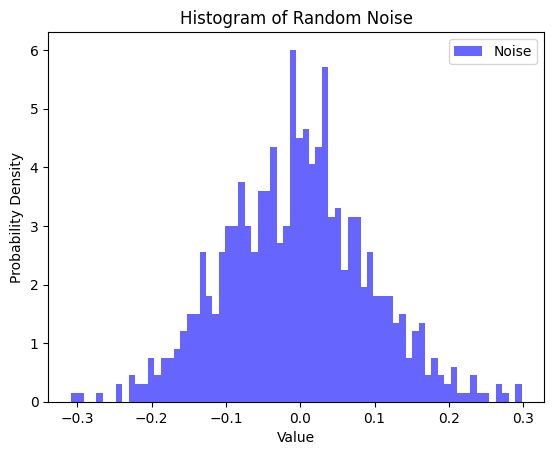

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mean = 0.0
std_dev = 0.1
vector_representation = 768
# Generate random noise
noise = np.random.normal(mean, std_dev, size=vector_representation)
# Create a histogram
plt.hist(noise, bins=70, density=True, alpha=0.6, color='b', label='Noise')
# Add labels and a legend
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Histogram of Random Noise')
plt.legend()
# Display the plot
plt.show()

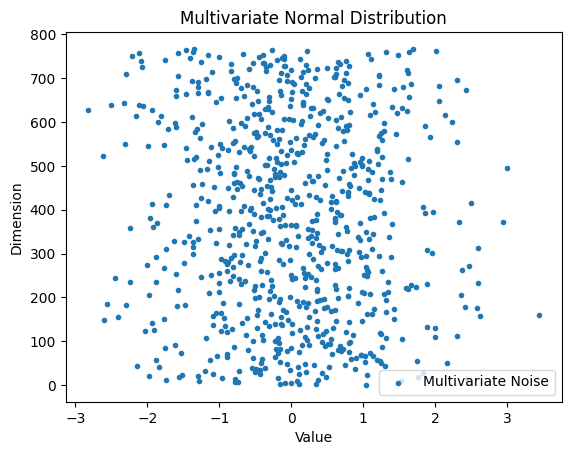

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
vector_representation = 768
# Mean of the multivariate distribution
mean = np.zeros(vector_representation)
# Covariance matrix of the distribution (identity matrix in this case)
covariance = np.eye(vector_representation)
# Generate random noise
noise = np.random.multivariate_normal(mean, covariance, size=1)
# Create a scatter plot for the multivariate normal distribution
plt.scatter(noise[0], range(vector_representation), marker='.', label='Multivariate Noise')
# Add labels and a legend
plt.xlabel('Value')
plt.ylabel('Dimension')
plt.title('Multivariate Normal Distribution')
plt.legend()
# Display the plot
plt.show()

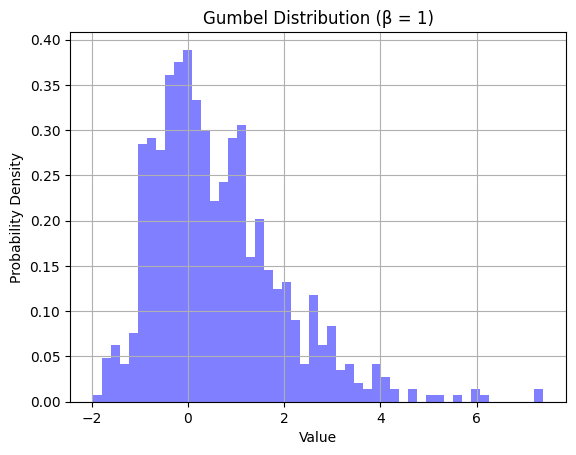

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.gumbel import Gumbel
import torch

# Set β to your desired value
b = 1
gumbel_dist = Gumbel(0, b)
num_samples = 768

# Generate Gumbel samples as a NumPy array
gumbel_samples = gumbel_dist.sample((1, num_samples)).numpy()

# Plot a histogram of the samples
plt.hist(gumbel_samples.flatten(), bins=50, density=True, alpha=0.5, color='b')
plt.title(f'Gumbel Distribution (β = {b})')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [ ]:
def mahalanobis_distance(x, y, cov):
    # Calculate the difference between the data point and the mean
    diff = x - y
    # Calculate the Mahalanobis distance using the formula:
    # D(x) = sqrt((x - mean)^T * cov^-1 * (x - mean))
    inv_cov = np.linalg.inv(cov)
    mahalanobis_dist = np.sqrt(np.dot(np.dot(diff, inv_cov), diff))
    
    return mahalanobis_dist

# Other Metric Differential Privacy
- BRR - Randomized Response (Hamming distance)
    https://arxiv.org/abs/2107.07923
- Manhattan distance & Hyperbolic distance
    https://arxiv.org/abs/1811.10256
- Euclidean distance
    This paper
- Mahalanobis Metric
    https://aclanthology.org/2020.privatenlp-1.2.pdf
- Vickrrey Mechanism
    https://arxiv.org/abs/1910.08917
- Truncated Gumbel distribution
    https://arxiv.org/pdf/2107.07928.pdf    